# Detect fake tweet with logistic regression


# Importing library


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
#nltk.download('wordnet')
from nltk.corpus import stopwords
#nltk.download('stopwords')
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
#nltk.download('punkt')
import sklearn as sk #this is the most popular library for statistics and machine learning
import matplotlib.pyplot as plt 
import os
import itertools
import collections
import re
import textstat
import networkx
import warnings
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import wordnet as wn
from nltk import pos_tag
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score
from sklearn import metrics
import string
from collections import Counter


## Reading data and summarizing

In [3]:
df = pd.read_csv('../input/fakenews/tweets_labeled.csv')
df.head(10)

,tweet_id,text,label
0,1161040537207463936,'RT @SenJeffMerkley: The Endangered Species Ac...,1
1,1176360756239118342,'RT @LindseyGrahamSC: Interesting concept -- i...,1
2,1099036648573145088,'RT @RealJamesWoods: #BuildTheWall #DeportThem...,0
3,1092915693203480577,'RT @PatriotJackiB: Why would the MEXICAN GOV’...,0
4,1149038450668187654,'RT @TheOnion: Sweden Announces Plan To Get 10...,0
5,1175456815674343424,'RT @kcResister: Warren: 'Congress is complici...,1
6,1180809117310623744,'RT @ShimonPro: A dozen current and former sta...,1
7,1179840318935576578,'RT @samstein: This is a bombshell that isn’t ...,1
8,1081722778125062144,'Planned Parenthood Erects Billboards Urging W...,0
9,1158761795739217921,'https://t.co/MvrznF1fWVWhoever obstructing th...,1


In [4]:
df = df[['text','label']]

## Extract Features

In [5]:
def contains_hashtag(tweet):
    if '#' in tweet:
        return 1
    else:
        return 0

In [6]:
df['contains_hashtag'] = df['text'].apply(lambda x: contains_hashtag(x))

In [7]:
def count_hashtag(tweet):
    return tweet.count('#')

In [8]:
df['count_hashtag'] = df['text'].apply(lambda x: count_hashtag(x))

In [9]:
def contains_link(tweet):
    #if a tweet contains a link (has 'https://' in it) return 1 (true) otherwise return 0 (false)
    if 'https://' in tweet:
        return 1
    else:
        return 0

In [10]:
df['contains_link'] = df['text'].apply(lambda x: contains_link(x))

In [11]:
def count_link(tweet):
    return tweet.count('https://')

In [12]:
df['count_link'] = df['text'].apply(lambda x: contains_link(x))

In [13]:
def contains_mention(tweet):
    if '@' in tweet:
        return 1
    else:
        return 0

In [14]:
df['contains_mention'] = df['text'].apply(lambda x: contains_mention(x))

In [15]:
def count_mention(tweet):
    return tweet.count('@')

In [16]:
df['count_mention'] = df['text'].apply(lambda x: count_mention(x))

In [17]:
def is_retweet(tweet):
    regexp = re.compile('(RT @.*: )')
    if regexp.search(tweet):
        return 1
    else:
        return 0

In [18]:
df['is_retweet'] = df['text'].apply(lambda x: is_retweet(x))

In [19]:
def count_3dots(tweet):
    return tweet.count('…') + tweet.count('...')

In [20]:
df['count_3dots'] = df['text'].apply(lambda x: count_3dots(x))

In [21]:
def count_capital_letters(tweet):
    return sum(1 for c in tweet if c.isupper())

In [22]:
df['count_capital_letters'] = df['text'].apply(lambda x: count_capital_letters(x))

In [23]:
def count_capital_letters_to_length(tweet):
    return sum(1 for c in tweet if c.isupper()) / len(tweet)

In [24]:
df['count_capital_letters_to_length'] = df['text'].apply(lambda x: count_capital_letters_to_length(x))

In [25]:
stop_words = set(stopwords.words('english'))
def count_stop_words(tweet):
    word_tokens = word_tokenize(tweet)
    return sum(1 for w in word_tokens if w in stop_words)

In [26]:
df['count_stop_words'] = df['text'].apply(lambda x: count_stop_words(x))

In [27]:
def count_special_chars(tweet):
    word_tokens = word_tokenize(tweet)
    return sum(1 for w in word_tokens if w in stop_words)

In [28]:
df['count_special_chars'] = df['text'].apply(lambda x: count_special_chars(x))

In [29]:
def count_special_chars(tweet):
    count = 0
    for i in range(0, len(tweet)):
    # len(string) function to count the 
    # number of characters in given string.      
        #.isalpha() function checks whether character 
        #is alphabet or not.
        if (tweet[i].isalpha()):
            continue
        #.isdigit() function checks whether character 
        #is a number or not.
        elif (tweet[i].isdigit()):
            continue
        else:
            count += 1
            
    return count

In [30]:
df['count_special_chars'] = df['text'].apply(lambda x: count_special_chars(x))

In [31]:
def count_digits(tweet): 
    count = 0
    for i in range(0, len(tweet)):
        if (tweet[i].isdigit()):
            count += 1
    return count

In [32]:
df['count_digits'] = df['text'].apply(lambda x: count_digits(x))

In [33]:
def count_alphabets(tweet): 
    count = 0
    for i in range(0, len(tweet)):
        if (tweet[i].isalpha()):
            count += 1
    return count

In [34]:
df['count_alphabets'] = df['text'].apply(lambda x: count_alphabets(x))

Before cleaning (bc)

In [35]:
df['bc_length'] = df['text'].apply(lambda x: len(x))
df['bc_words_count'] = df['text'].apply(lambda x: len(x.split()))
df['bc_words_average_length'] = df['text'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()))

In [36]:
# Remove emojies from code
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', text)

In [37]:
df['text'] = df['text'].apply(lambda x: remove_emoji(x))

In [38]:
df['count_open_parentheses'] = df['text'].apply(lambda x: x.count('('))
df['count_close_parentheses'] = df['text'].apply(lambda x: x.count(')'))
df['count_exclamation_mark'] = df['text'].apply(lambda x: x.count('!'))
df['count_question_mark'] = df['text'].apply(lambda x: x.count('?'))
df['count_|'] = df['text'].apply(lambda x: x.count('|'))
df['count_percentage_sign'] = df['text'].apply(lambda x: x.count('%'))
df['count_comma'] = df['text'].apply(lambda x: x.count(','))
df['count_plus'] = df['text'].apply(lambda x: x.count('+'))
df['count_minus'] = df['text'].apply(lambda x: x.count('-'))

## Cleaning

In [39]:
def clean_word():
    word = df['text'].str.replace(r'RT\s', '')
    word = word.str.replace("}", "")
    word = word.str.replace("{", "")
    word = word.str.replace("-", "")
    word = word.str.replace("--", "")
    word = word.str.replace("|", "")
    word = word.str.replace("¦", "")
    word = word.str.replace(",", "")
    word = word.str.replace(".", "")
    word = word.str.replace(":", "")
    word = word.str.replace("?", "")
    word = word.str.replace("#", "")
    word = word.str.replace("(", "")
    word = word.str.replace(")", "")
    word = word.str.replace("!", "")
    word = word.str.replace(";", "")
    word = word.str.replace("&", "")
    word = word.str.replace("'", "")
    word = word.str.replace('—', "")
    word = word.str.replace("i'm", "i am")
    word = word.str.replace("it's", "it is")
    word = word.str.replace(r'RT\s', '')
    word = word.str.replace(r'@\S*?\s', '')
    word = word.str.replace(r'@\S*?$', '')
    word = word.str.replace(r'https\S*?\s', ' ')  
    word = word.str.replace(r'https\S*?$', '')
    word = word.str.replace('\'', '')
    word = word.str.replace(r'…', '')
    word = word.str.replace(r'\s$', '')
    df['text'] = word 

In [40]:
clean_word()

In [41]:
stop = stopwords.words('english')

def words_only_count(tweet):
    words = tweet.split()
    words_only = [word for word in words if word not in stop and
              not word.startswith(('#', '@'))]
    return len(words_only)

Negative words:

In [42]:
df['count_illegal'] = df['text'].apply(lambda x: x.lower().count('illegal'))
df['count_breitbart'] = df['text'].apply(lambda x: x.lower().count('breitbart'))
df['count_alien'] = df['text'].apply(lambda x: x.lower().count('alien'))
df['count_bad'] = df['text'].apply(lambda x: x.lower().count('bad'))

positive words:

In [43]:
df['count_good'] = df['text'].apply(lambda x: x.lower().count('good'))
df['count_great'] = df['text'].apply(lambda x: x.lower().count('great'))

In [44]:
df['words_only_count'] = df['text'].apply(lambda x: words_only_count(x))

After cleaning (ac)

In [45]:
df['ac_length'] = df['text'].apply(lambda x: len(x))
df['ac_words_count'] = df['text'].apply(lambda x: len(x.split()))
# df['ac_words_average_length'] = df['text'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()))

In [46]:
df['readability'] = df['text'].apply(textstat.flesch_reading_ease)

In [47]:
df.head()

,text,label,contains_hashtag,count_hashtag,contains_link,count_link,contains_mention,count_mention,is_retweet,count_3dots,...,count_illegal,count_breitbart,count_alien,count_bad,count_good,count_great,words_only_count,ac_length,ac_words_count,readability
0,The Endangered Species Act saved the bald eagl...,1,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,13,117,21,58.62
1,Interesting concept impeach first find facts ...,1,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,16,111,17,45.76
2,BuildTheWall DeportThemAll,0,1,2,1,1,1,1,1,0,...,0,0,0,0,0,0,2,27,2,-91.30
3,Why would the MEXICAN GOV’T fund this Who are ...,0,0,0,1,1,1,1,1,0,...,0,0,0,0,0,0,7,66,13,83.66
4,Sweden Announces Plan To Get 100% Of Energy Fr...,0,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,16,90,16,55.24


In [48]:
df.columns

Index(['text', 'label', 'contains_hashtag', 'count_hashtag', 'contains_link',
       'count_link', 'contains_mention', 'count_mention', 'is_retweet',
       'count_3dots', 'count_capital_letters',
       'count_capital_letters_to_length', 'count_stop_words',
       'count_special_chars', 'count_digits', 'count_alphabets', 'bc_length',
       'bc_words_count', 'bc_words_average_length', 'count_open_parentheses',
       'count_close_parentheses', 'count_exclamation_mark',
       'count_question_mark', 'count_|', 'count_percentage_sign',
       'count_comma', 'count_plus', 'count_minus', 'count_illegal',
       'count_breitbart', 'count_alien', 'count_bad', 'count_good',
       'count_great', 'words_only_count', 'ac_length', 'ac_words_count',
       'readability'],
      dtype='object')

## Correlation between features and label

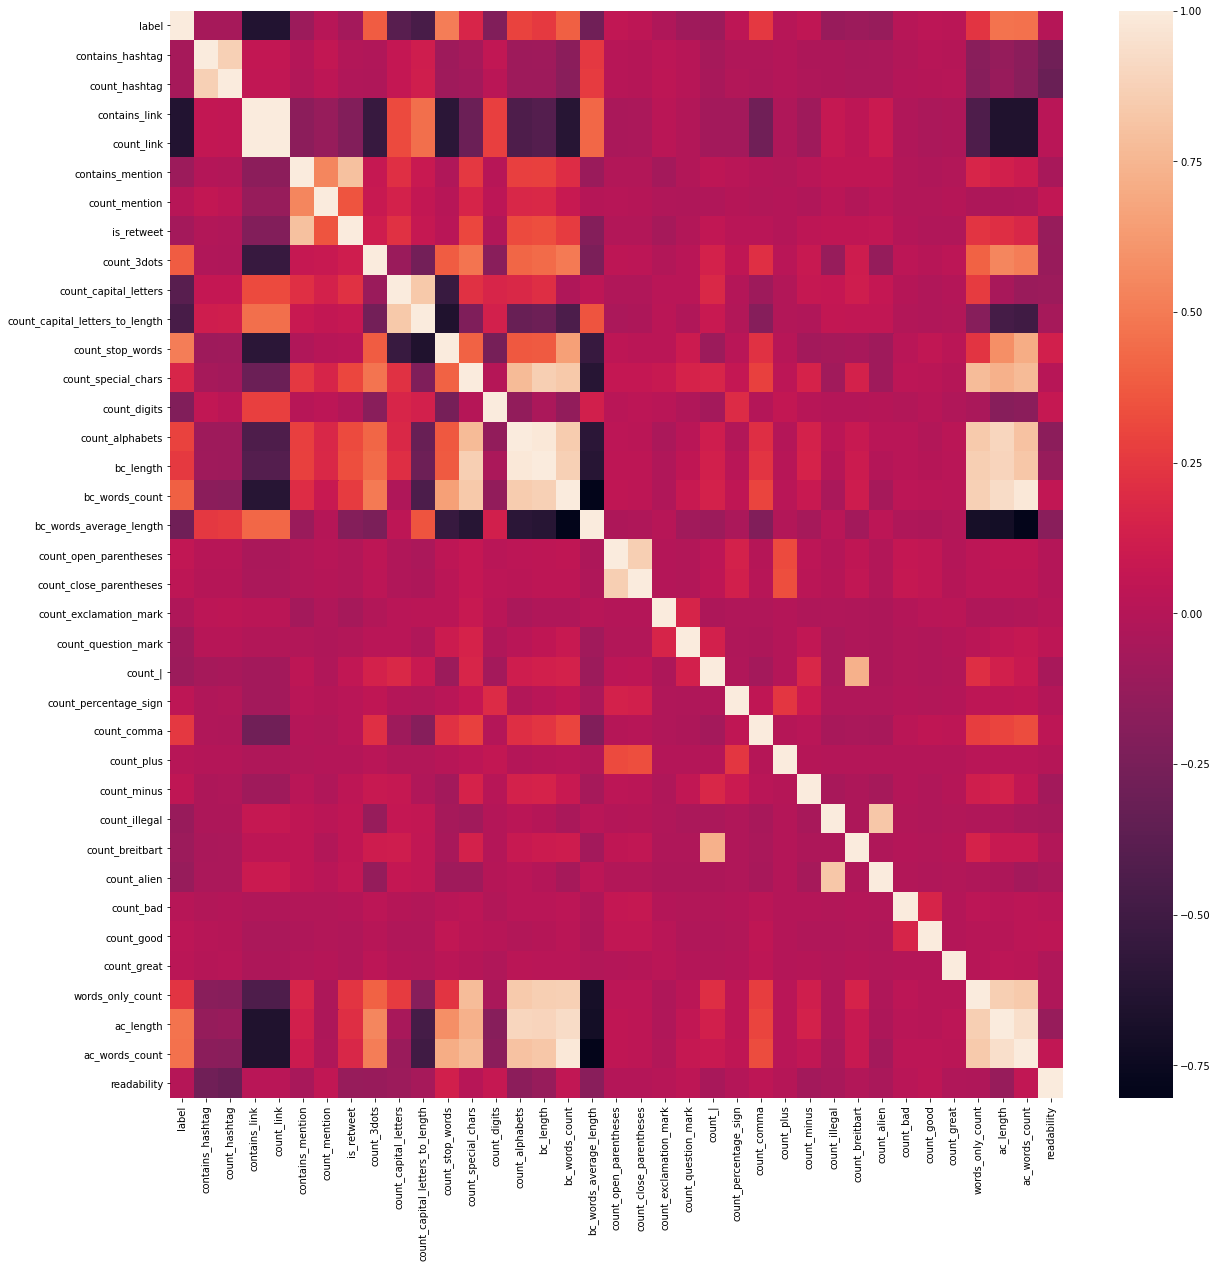

In [49]:
plt.figure(figsize=(20,20))
sns.heatmap(df.loc[:, ~df.columns.isin(['text'])].corr())